In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
import sys
# sys.path.append('/lhome/ific/a/aamerio/github/diffusion/src')
# sys.path.append('/home/zaldivar/Documents/Aurelio/Github/diffusion/src')
sys.path.append('../src')
sys.path.append('../reference/simformer-main/src/probjax/probjax')

import os
# os.environ['JAX_PLATFORMS']="cpu"

In [3]:
import diffusion
from diffusion.sbi.transformer import Transformer
from diffusion.embedding import GaussianFourierEmbedding, SinusoidalEmbedding
from diffusion import sde

/home/zaldivar/miniforge3/envs/diffusion/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-19 15:39:02.496628: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:0: CUDA error: : CUDA_ERROR_UNKNOWN: unknown error


RuntimeError: Unable to initialize backend 'cuda': INTERNAL: no supported devices found for platform CUDA (you may need to uninstall the failing plugin package, or set JAX_PLATFORMS=cpu to skip this backend.)

In [4]:
ve = sde.VESDE(2, sigma_min=1e-5, sigma_max=15.)

In [5]:
import jax 
import jax.numpy as jnp
import numpy as np
from flax import nnx
from functools import partial

import matplotlib.pyplot as plt


from tqdm.auto import tqdm

In [ ]:
print(jax.default_backend())
print(jax.devices())

gpu
[CudaDevice(id=0)]


# generate dataset

In [7]:
# we have two parameters, theta1 and theta2
# we have two outputs, y1 and y2, corresponding to the measurement with two different detectors

npoints = 2**10 #1024

nobs = 128_000
wavefun = lambda theta1, theta2, x: jnp.sin(theta1*x)*jnp.cos(theta2*x)


rng = jax.random.PRNGKey(42)
rng, key = jax.random.split(rng)
x1 = np.linspace(0, 4*np.pi, npoints).reshape(1,-1)
x2 = np.linspace(0, 4*np.pi, npoints).reshape(1,-1)
thetas = jax.random.normal(key, (nobs,2))+0.5
noise1 = jax.random.normal(key, (nobs,npoints))*0.3
noise2 = jax.random.normal(key, (nobs,npoints))*0.3

xs1 = wavefun(thetas[:,0:1], thetas[:,1:2],x1) + noise1
xs2 = wavefun(thetas[:,0:1], thetas[:,1:2],x2) + noise2

xs1 = xs1.reshape(nobs,1,npoints)
xs2 = xs2.reshape(nobs,1,npoints)

xs = jnp.concatenate([xs1,xs2],axis=1)


In [ ]:
xs.shape, thetas.shape

((128000, 2, 1024), (128000, 2))

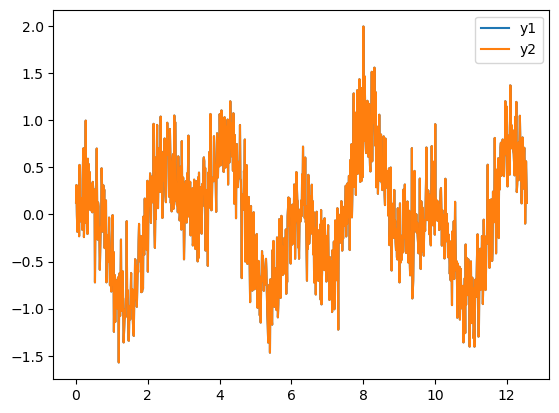

In [9]:
i=5
plt.plot(x1[0,:], xs1[i,0,:], label='y1')
plt.plot(x2[0,:], xs2[i,0,:], label='y2')
plt.legend()
plt.show()

# data preprocessing

In [10]:
thetas_mean = jnp.mean(thetas, axis=0, keepdims=True)
thetas_std = jnp.std(thetas, axis=0, keepdims=True)

thetas = (thetas - thetas_mean) / thetas_std

In [11]:
def z_score_thetas(thetas):
    thetas = (thetas - thetas_mean) / thetas_std
    return thetas

def un_z_score_thetas(thetas):
    thetas = thetas * thetas_std + thetas_mean
    return thetas

In [12]:
xs_mean = jnp.mean(xs, axis=0, keepdims=True)
xs_mean = jnp.mean(xs_mean, axis=-1, keepdims=True)
xs_std = jnp.std(xs, axis=0, keepdims=True)
xs_std = jnp.std(xs_std, axis=-1, keepdims=True)

xs = (xs - xs_mean) / xs_std

In [13]:
def z_score_xs(xs):
    xs = (xs - xs_mean) / xs_std
    return xs

def un_z_score_xs(xs):
    xs = xs * xs_std + xs_mean
    return xs

In [14]:
def ravel(data, axis=-1):
    flat_data, tree = jax.tree_util.tree_flatten(data)
    split_dims = np.cumsum(np.array([flat.shape[axis] for flat in flat_data]))[:-1]
    flat_data = jnp.concatenate(flat_data, axis=axis)
    def unravel(flat_data):
        flat_data = jnp.split(flat_data, split_dims, axis=axis)
        flat_data = jax.tree_util.tree_unflatten(tree, flat_data)
        return flat_data
    def unflatten(flat_data):
        flat_data = jnp.split(flat_data, split_dims, axis=axis)
        return flat_data 
    return flat_data, unravel, unflatten

In [15]:
data = {"theta0": thetas[:, 0][:, None], "theta1": thetas[:, 1][:, None], "x0": xs[:, 0], "x1": xs[:, 1]}
data_flat, unravel, unflatten = ravel(data)
theta_dim = 2
x_dim = data_flat.shape[-1] - theta_dim
node_id = jnp.arange(0, 4)
condition_mask = jnp.array([False]*theta_dim + [True]*x_dim)

In [16]:
# Model output scale function
scale_min=0
def output_scale_fn(t, x):
    scale = jnp.clip(jnp.sqrt(jnp.sum(ve.variance(t[..., None]))), scale_min)
    return 1/scale[..., None] * x

In [17]:
# we define a CNN to embed the data
class ConvEmbed(nnx.Module):
    def __init__(self, din, dout, *, rngs):
        features = 16
        padding = "SAME"
        self.activation = jax.nn.gelu
        dlin = din
        conv1 = nnx.Conv(1, features, kernel_size=(9,), strides=2, padding=padding, rngs=rngs) # 512
        dlin/=2
        bn1 = nnx.BatchNorm(features, rngs=rngs)
        conv2 = nnx.Conv(features, features*2, kernel_size=(6,), strides=2, padding=padding, rngs=rngs) # 256
        dlin/=2
        features *= 2
        bn2 = nnx.BatchNorm(features, rngs=rngs)
        conv3 = nnx.Conv(features, features*2, kernel_size=(3,), strides=2, padding=padding, rngs=rngs) # 128
        dlin/=2
        features *= 2
        bn3 = nnx.BatchNorm(features, rngs=rngs)
        conv4 = nnx.Conv(features, features*2, kernel_size=(3,), strides=2, padding=padding, rngs=rngs) # 64
        dlin/=2
        features *= 2
        bn4 = nnx.BatchNorm(features, rngs=rngs)
        conv5 = nnx.Conv(features, features*2, kernel_size=(3,), strides=2, padding=padding, rngs=rngs) # 32
        dlin/=2
        features *= 2
        bn5 = nnx.BatchNorm(features, rngs=rngs)
        conv6 = nnx.Conv(features, features, kernel_size=(3,), strides=2, padding=padding, rngs=rngs) # 16
        dlin/=2
        bn6 = nnx.BatchNorm(features, rngs=rngs)
        conv7 = nnx.Conv(features, features*2, kernel_size=(3,), strides=2, padding=padding, rngs=rngs) # 8
        dlin/=2
        features*=2
        bn7 = nnx.BatchNorm(features, rngs=rngs)
        conv8 = nnx.Conv(features, features, kernel_size=(3,), strides=2, padding=padding, rngs=rngs) # 4
        dlin/=2
        bn8 = nnx.BatchNorm(features, rngs=rngs)
        dlin*=features

        self.conv_layers = [conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8]
        self.bn_layers = [bn1, bn2, bn3, bn4, bn5, bn6, bn7, bn8]

        self.linear = nnx.Linear(int(dlin), dout, rngs=rngs)
    
    def __call__(self, x):
        for i in range(len(self.conv_layers)):
            x = self.conv_layers[i](x)
            x = self.activation(x)
            x = self.bn_layers[i](x)
        
        #flatten x
        x = x.reshape(x.shape[0], -1)
        x = self.linear(x)
        
        return x[..., None,:]



In [18]:
x_dim

2048

In [19]:
token_dim = 100
id_dim = 40
cond_dim = 10
rngs = nnx.Rngs(42)


class Simformer(nnx.Module):
    def __init__(self, din, *, rngs):
        fourier_features = 128
        self.unflatten = unflatten
        embedding_net1 = lambda x: jnp.repeat(x, token_dim, axis=-1)
        embedding_net2 = ConvEmbed(din, token_dim, rngs=rngs)
        self.embedding_nets = [
            embedding_net1,
            embedding_net1,
            embedding_net2,
            embedding_net2,
        ]
        # self.time_embedder = GaussianFourierEmbedding(fourier_features, rngs=rngs)
        self.time_embedder = SinusoidalEmbedding(fourier_features)
        self.id_embedder = nnx.Embed(
            num_embeddings=4, features=id_dim, rngs=rngs
        )  # hk.Embed(4, id_dim)
        self.condition_token = nnx.Param(0.01*jnp.ones((1, 1, cond_dim)))
        self.output_scale_fn = output_scale_fn

        self.total_tokens = token_dim + id_dim + cond_dim

        self.transformer = Transformer(
            din=self.total_tokens,
            dcontext=fourier_features,
            num_heads=4,
            num_layers=8,
            features=20,
            widening_factor=3,
            dropout_rate=0,
            num_hidden_layers=1,
            act=jax.nn.gelu,
            skip_connection_attn=False,
            skip_connection_mlp=False,
            rngs=rngs,
        )

        self.output_fn = [nnx.Linear(self.total_tokens,1,rngs=rngs), nnx.Linear(self.total_tokens,1,rngs=rngs), nnx.Linear(self.total_tokens,npoints,rngs=rngs), nnx.Linear(self.total_tokens,npoints,rngs=rngs)]


    def __call__(self, data, t, data_id, condition_mask, edge_mask=None):
        data = self.unflatten(data)
        
        data_embedded = jax.tree.map(lambda x, net: net(x[..., :,None]), data, self.embedding_nets)

        data_embedded = jnp.concatenate(data_embedded, axis=-2)
        
        _, current_nodes, _ = data_embedded.shape
        
        
        id_embedding = self.id_embedder(data_id)
        id_embedding = jnp.broadcast_to(
            id_embedding, data_embedded.shape[:-1] + (id_dim,)
        )
        tokens = jnp.concatenate([data_embedded, id_embedding], axis=-1)
        # time = self.time_embedder(t[..., None])
        time = self.time_embedder(t)
        
        condition_mask = self.unflatten(condition_mask)
        condition_mask = jax.tree.map(lambda x: jnp.any(x, axis=-1, keepdims=True), condition_mask)
        condition_mask = jnp.concatenate(condition_mask, axis=-1)
        condition_mask = condition_mask.reshape(-1, current_nodes, 1)
        condition_token = condition_mask * self.condition_token
    
        condition_token = jnp.broadcast_to(
            condition_token, tokens.shape[:-1] + (cond_dim,)
        )

        tokens = jnp.concatenate([tokens, condition_token], -1)

        h = self.transformer(tokens, context=time, mask=edge_mask)
        out = jnp.split(h, current_nodes, axis=-2)
        out = jax.tree.map(lambda x, fn: fn(x), out, self.output_fn)
        out = jnp.concatenate(out, axis=-1)
        out = jnp.squeeze(out, axis=-2)
        out = output_scale_fn(t, out)

        return out

In [20]:
score_model = Simformer(x_dim//2, rngs=rngs)

In [21]:
score_model( data_flat[:10], jnp.ones((1,)), node_id, condition_mask).shape

(10, 2050)

In [22]:
import optax
optimizer = nnx.Optimizer(score_model, optax.adam(1e-4))  

In [23]:
# def denoising_score_matching_loss(
#     score_model,
#     key,
#     times,
#     xs_target,
#     loss_mask,
#     *args,
#     mean_fn,
#     std_fn,
#     weight_fn,
#     axis: int = -2,
#     rebalance_loss: bool = False,
#     **kwargs,
# ):
#     """This function computes the denoising score matching loss. Which can be used to train diffusion models.

#     Args:
#         params (PyTree): Parameters of the model_fn given as a PyTree.
#         key (PRNGKey): Random generator key.
#         times (Array): Time points, should be broadcastable to shape (batch_size, 1).
#         xs_target (Array): Target distribution.
#         loss_mask (Optional[Array]): Mask for the target distribution. If None, no mask is applied, should be broadcastable to shape (batch_size, 1).
#         model_fn (Callable): Score model that takes parameters, times, and samples as input and returns the score. Should be a function of the form model_fn(params, times, xs_t, *args) -> s_t.
#         mean_fn (Callable): Mean function of the SDE.
#         std_fn (Callable): Std function of the SDE.
#         weight_fn (Callable): Weight function for the loss.
#         axis (int, optional): Axis to sum over. Defaults to -2.
        

#     Returns:
#         Array: Loss
#     """
#     eps = jax.random.normal(key, shape=xs_target.shape)
#     mean_t = mean_fn(xs_target, times)
#     std_t = std_fn(xs_target, times)
#     xs_t = mean_t + std_t * eps
    
#     if loss_mask is not None:
#         loss_mask = loss_mask.reshape(xs_target.shape)
#         xs_t = jnp.where(loss_mask, xs_target, xs_t)
    
#     score_pred = score_model(xs_t, times, *args, **kwargs)
#     score_target = -eps / std_t

#     loss = (score_pred - score_target) ** 2
#     if loss_mask is not None:
#         loss = jnp.where(loss_mask, 0.0,loss)
#     loss = weight_fn(times) * jnp.sum(loss, axis=axis, keepdims=True)
#     if rebalance_loss:
#         num_elements = jnp.sum(~loss_mask, axis=axis, keepdims=True)
#         loss = jnp.where(num_elements > 0, loss / num_elements, 0.0)
#     loss = jnp.mean(loss)

#     return loss

In [24]:
@nnx.jit
def train_step(score_model, optimizer, data, node_id, rngs):
    """
    params: the current weights of the model
    rng: random number generator from jax
    batch: a batch of samples from the training data, representing samples from \mu_text{data}, shape (J, N)
    opt_state: the internal state of the optimizer
    model: the score function

    takes the gradient of the loss function and updates the model weights (params) using it. Returns
    the value of the loss function (for metrics), the new params and the new optimizer state
    """
    rng = rngs.params()
    key_times, key_loss, key_condition = jax.random.split(rng,3)
    
    loss_fn_ = ve.get_loss_function()
    #times = jax.random.uniform(key_times, (data.shape[0],1), minval=0, maxval =1)

    condition_mask1 = jnp.array([False]*theta_dim + [True]*x_dim)
    condition_mask2 = jnp.array([False]*theta_dim + [True]*(x_dim//2) + [False]*(x_dim//2))
    condition_mask3 = jnp.array([False]*theta_dim + [False]*(x_dim//2) + [True]*(x_dim//2))

    edge_mask1 = jnp.ones((4,4), dtype=bool)
    # Partial posterior
    edge_mask2 = edge_mask1.at[:, 2].set(False)
    edge_mask2 = edge_mask2.at[2, :].set(False)
    # Partial posterior 2
    edge_mask3 = edge_mask1.at[:, 3].set(False)
    edge_mask3 = edge_mask3.at[3, :].set(False)
    
    edge_masks = jax.random.choice(key_condition, jnp.stack([edge_mask1, edge_mask2, edge_mask3]), (data.shape[0],))
    condition_mask = jax.random.choice(key_condition, jnp.stack([condition_mask1, condition_mask2, condition_mask3]), (data.shape[0],))
    l_mask = jnp.broadcast_to(condition_mask1, (data.shape[0],) + condition_mask1.shape)


    #weight_fn = lambda t: ve.diffusion(1.0, t)**2  # MLE

    #loss_fn = lambda score_model: denoising_score_matching_loss(score_model, key_loss, times, data, l_mask, node_id, mean_fn = ve.marginal_mean, std_fn=ve.marginal_std, weight_fn=weight_fn, edge_mask=edge_masks, condition_mask=condition_mask, axis=-1)

    loss_fn = lambda score_model: loss_fn_(score_model, data, l_mask, node_id, rng=key_loss, edge_mask=edge_masks, condition_mask=condition_mask)

    loss, grads = nnx.value_and_grad(loss_fn)(score_model)
    optimizer.update(grads)  # In place updates.
    return loss

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2881878/1861972405.py:3: SyntaxWarning: invalid escape sequence '\m'
  """


In [25]:
nepochs = 10
batch_size = 128
batch_steps = nobs // batch_size 


for _ in range(nepochs):
    pbar = tqdm(range(batch_steps))
    subkey = rngs.batch()
    data_batches = jax.random.choice(subkey, data_flat, (batch_steps, batch_size), replace=False)
    l = 0
    for j in pbar:
        loss = train_step(score_model, optimizer, data_batches[j], node_id, rngs)
        l += loss.item()
        if j % 10 == 0:
            pbar.set_postfix(loss=l/10)
            l = 0
    # print(l)

  0%|          | 0/1000 [00:00<?, ?it/s]

E0117 19:23:14.590732 2881878 buffer_comparator.cc:157] Difference at 16: -5.55155, expected 2.39472
E0117 19:23:14.590793 2881878 buffer_comparator.cc:157] Difference at 17: -2.39444, expected 2.497
E0117 19:23:14.590802 2881878 buffer_comparator.cc:157] Difference at 18: 0.748223, expected 2.46666
E0117 19:23:14.590809 2881878 buffer_comparator.cc:157] Difference at 19: -4.4611, expected 2.55935
E0117 19:23:14.590816 2881878 buffer_comparator.cc:157] Difference at 20: 3.62548, expected 2.70233
E0117 19:23:14.590821 2881878 buffer_comparator.cc:157] Difference at 21: 0.157913, expected 2.7922
E0117 19:23:14.590828 2881878 buffer_comparator.cc:157] Difference at 22: -13.4689, expected 2.96119
E0117 19:23:14.590835 2881878 buffer_comparator.cc:157] Difference at 23: -9.77329, expected 2.25285
E0117 19:23:14.590841 2881878 buffer_comparator.cc:157] Difference at 24: -20.8019, expected 2.65449
E0117 19:23:14.590848 2881878 buffer_comparator.cc:157] Difference at 25: -18.8025, expected 2.7

# now we do the backward diffusion to get the posterior

In [26]:
from functools import partial
from probjax.utils.sdeint import sdeint


# Reverse SDE drift
def drift_backward(t, x, node_ids=None, condition_mask=None, edge_mask=None, score_fn = model_fn):
    score = score_fn(params, t.reshape(-1, 1), x[None,...], node_ids,condition_mask, edge_mask=edge_mask)
    score = score.reshape(x.shape)

    f =  sde.drift(t,x) - sde.diffusion(t,x)**2 * score
    f = f * (1-condition_mask)
    
    return f.reshape(x.shape)

# Reverse SDE diffusion
def diffusion_backward(t,x, **kwargs):
    #t = T - t
    b =  sde.diffusion(t,x) 
    b = b * (1-condition_mask)
    return b.reshape(x.shape)

In [ ]:
def sample_fn(score_model, key, shape, node_ids,condition_mask, condition_value, time_steps=1001, edge_mask=None):
    score_fn = lambda xt, t: score_model(xt, t, data_id, condition_mask)

In [27]:
def sample_fn(score_model, key, shape, node_ids,condition_mask, condition_value, time_steps=1001, edge_mask=None):

    key1, key2 = jax.random.split(key, 2)
    # Sample from noise distribution at time 1
    x_T = jax.random.normal(key1, shape + (condition_value.shape[0],)) * end_std + end_mean

    
    x_T = x_T * (1-condition_mask) + condition_value * condition_mask
    # Solve backward sde
    keys = jax.random.split(key2, shape)
    # ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal", only_final=True), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn), lambda t, x: diffusion_backward(t, x), x_T, jnp.linspace(1.,T_min, time_steps))
    ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal"), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn), lambda t, x: diffusion_backward(t, x), x_T, jnp.linspace(1.,T_min, time_steps))
    return ys[:, -1, :]

In [55]:
nobs = 100

rng = jax.random.PRNGKey(420)
rng, key = jax.random.split(rng)
x1 = np.linspace(0, 4*np.pi, npoints).reshape(1,-1)
x2 = np.linspace(0, 4*np.pi, npoints).reshape(1,-1)
thetas_test = jax.random.normal(key, (nobs,2))+0.2
noise1 = jax.random.normal(key, (nobs,npoints))*0.3
noise2 = jax.random.normal(key, (nobs,npoints))*0.3

xs1 = wavefun(thetas_test[:,0:1], thetas_test[:,1:2],x1) + noise1
xs2 = wavefun(thetas_test[:,0:1], thetas_test[:,1:2],x2) + noise2

xs1 = xs1.reshape(nobs,1,npoints)
xs2 = xs2.reshape(nobs,1,npoints)

xs_test = jnp.concatenate([xs1,xs2],axis=1)

In [56]:
thetas_test = (thetas_test - thetas_mean) / thetas_std
xs_test = (xs_test - xs_mean) / xs_std

In [57]:
data_test = {"theta0": thetas_test[:, 0][:, None], "theta1": thetas_test[:, 1][:, None], "x0": xs_test[:, 0], "x1": xs_test[:, 1]}
data_test_flat, _, _ = ravel(data_test)

In [58]:
edge_mask = jnp.ones((4,4), dtype=bool)
edge_mask1 = edge_mask.at[:, 2].set(False)
edge_mask1 = edge_mask1.at[2, :].set(False)

edge_mask2 = edge_mask.at[:, 3].set(False)
edge_mask2 = edge_mask2.at[3, :].set(False)

In [59]:
index = 42
x_o = jax.device_put(data_test_flat[index], jax.devices("gpu")[0])
x_o[:2]

Array([-0.717,  1.153], dtype=float32)

In [60]:
sample = jnp.concatenate([sample_fn(jax.random.PRNGKey(0), (100,), node_id, condition_mask, x_o) for i in range(10)],axis=0)

In [70]:
sample.shape

(1000, 2050)

In [74]:
x_o_dict = unravel(x_o)

In [72]:
sample_partial1 = jnp.concatenate([sample_fn(jax.random.PRNGKey(1), (100,), node_id, condition_mask, x_o, edge_mask=edge_mask1) for i in range(10)],axis=0)
sample_partial2 = jnp.concatenate([sample_fn(jax.random.PRNGKey(2), (100,), node_id, condition_mask, x_o, edge_mask=edge_mask2) for i in range(10)],axis=0)

KeyboardInterrupt: 

In [75]:
sample = jax.device_put(sample, jax.devices("gpu")[0])
sample_partial1 = jax.device_put(sample_partial1, jax.devices("gpu")[0])
sample_partial2 = jax.device_put(sample_partial2, jax.devices("gpu")[0])
x_o = jax.device_put(data_test_flat[index], jax.devices("gpu")[0])

In [76]:
thetas_sampled = un_z_score_thetas(sample[:, :2])
thetas_partial1 = un_z_score_thetas(sample_partial1[:, :2])
thetas_partial2 = un_z_score_thetas(sample_partial2[:, :2])
theta_true = un_z_score_thetas(x_o[:2].reshape(1,-1))

In [97]:
num_samples = len(xs1[42,0,:])
frequencies = jnp.fft.fftfreq(num_samples,1.0)
fft_result = jnp.fft.fft(xs1[42,0,:])

idx = jnp.argsort(frequencies)
frequencies=frequencies[idx]
fft_result=fft_result[idx]

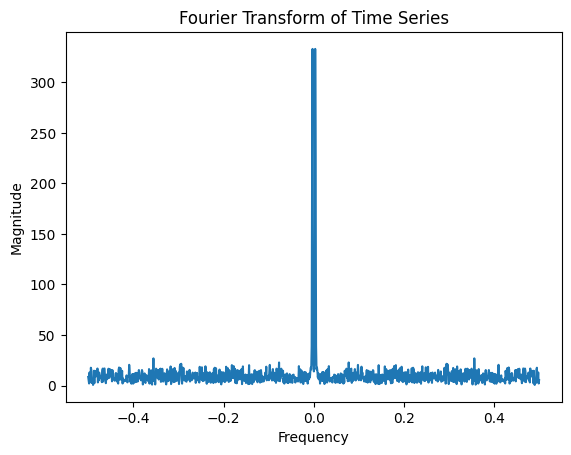

In [98]:
plt.plot(frequencies, jnp.abs(fft_result))
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Fourier Transform of Time Series')
plt.show()

In [85]:
fft_result

Array([ -14.033  +0.j   ,  -19.026  -6.582j,   -9.43  +21.004j, ...,
       -167.404+287.825j,   -9.43  -21.004j,  -19.026  +6.582j],      dtype=complex64)

In [104]:
import seaborn as sns
import pandas as pd

In [101]:
penguins = sns.load_dataset("penguins")

In [106]:
df = pd.DataFrame({"theta1":thetas_sampled[:, 0], "theta2":thetas_sampled[:, 1]})

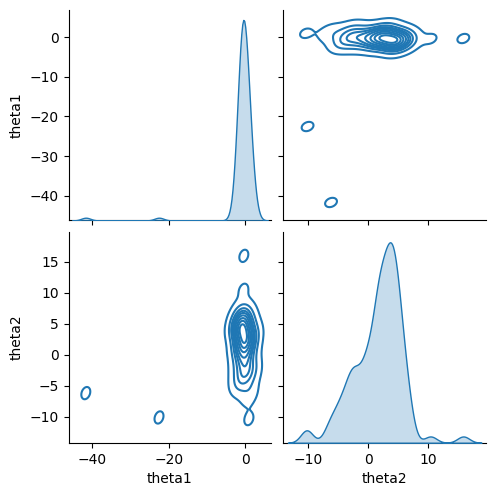

In [108]:
sns.pairplot(df,kind="kde")

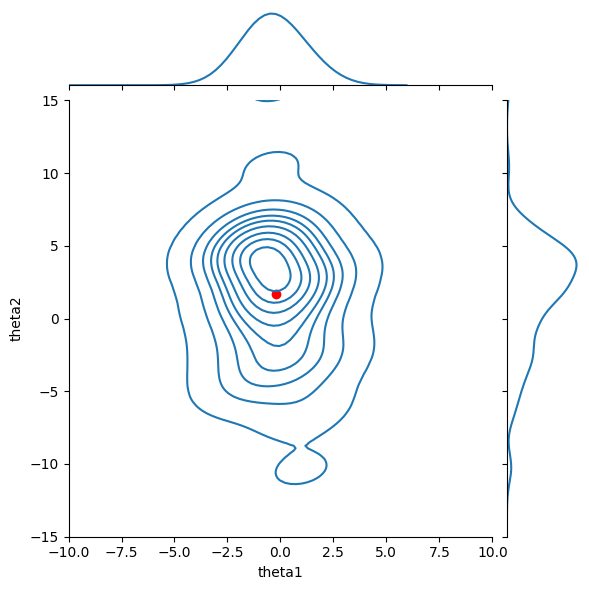

In [121]:
sns.jointplot(data=df,x="theta1", y="theta2", kind="kde", xlim=[-10,10], ylim=[-15,15])
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.show()

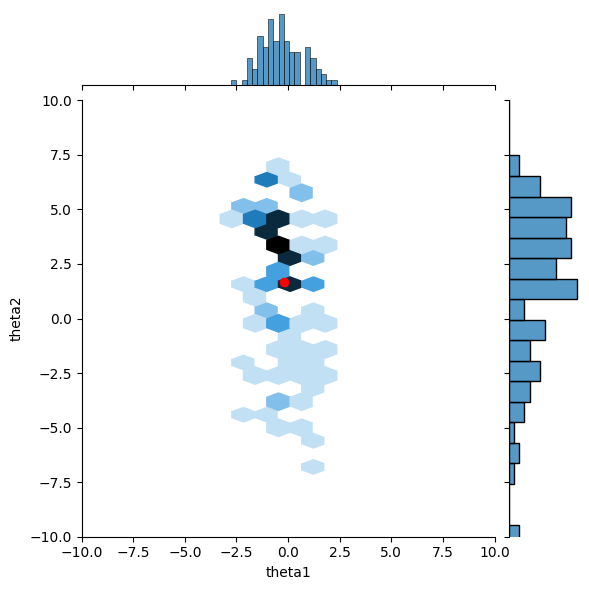

In [174]:
sns.jointplot(data=df,x="theta1", y="theta2", kind="hex", xlim=[-10,10], ylim=[-10,10])
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.show()

In [122]:
import corner

In [162]:
data_ = {"theta1":thetas_sampled[:, 0], "theta2":thetas_sampled[:, 1]}

In [177]:
theta_true

Array([[-0.217,  1.651]], dtype=float32)

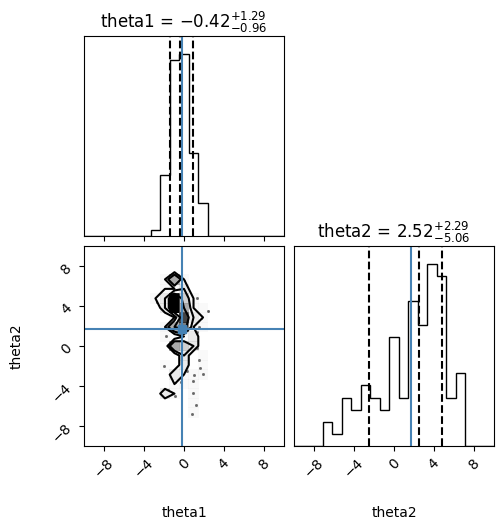

In [184]:
figure = corner.corner(data_, bins=21, range=[[-10,10],[-10,10]],
                       quantiles=[0.16, 0.5, 0.84],show_titles=True,
                       truths=theta_true[0],
                      plot_contours=True,
                      smooth=None)
#axes = np.array(figure.axes).reshape((2, 2))
#axes[1,0].scatter(theta_true[:,0], theta_true[:,1], color="red", zorder=10)
plt.show()

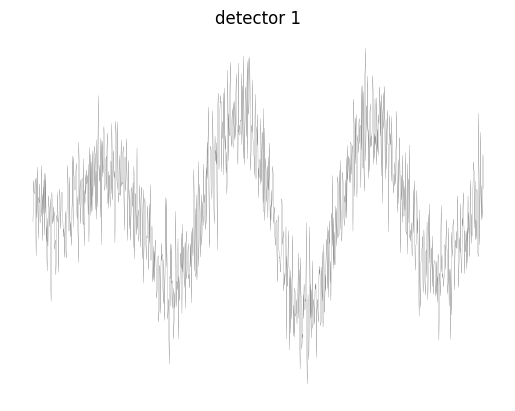

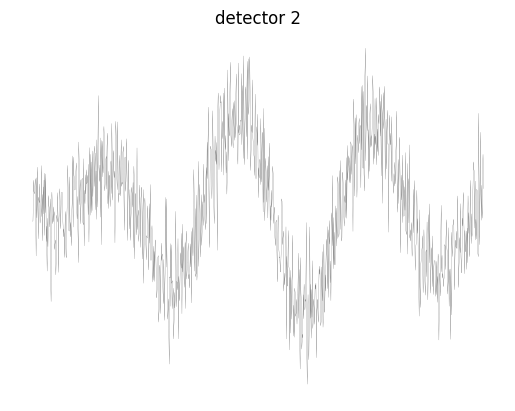

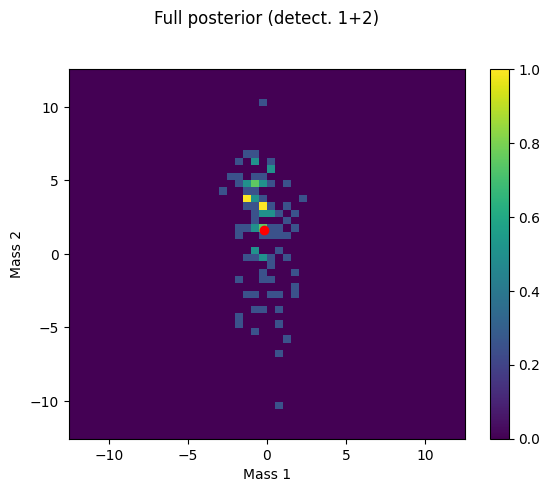

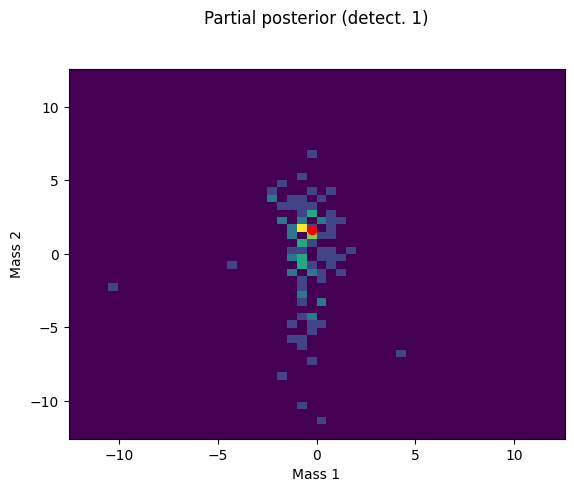

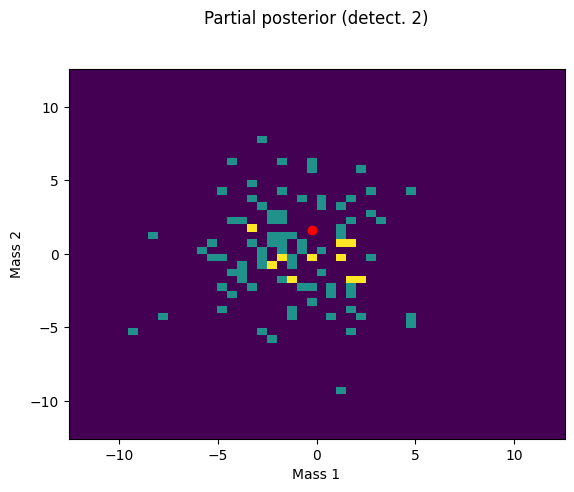

In [82]:
import matplotlib.gridspec as gridspec

# bins1 = np.linspace(-np.pi, np.pi, 101)
# bins2 = np.linspace(0, np.pi, 101)

#xlim = [-1,1]
#ylim=[1.2,2.0]
xlim = [-4*np.pi,4*np.pi]
ylim=[-4*np.pi,4*np.pi]

bins1 = np.linspace(*xlim, 51)
bins2 = np.linspace(*ylim, 51)


plt.plot(x_o_dict["x0"], lw=0.1, color="black")
plt.title("detector 1")
plt.axis("off")
plt.show()

plt.plot(x_o_dict["x1"],lw=0.1, color="black")
plt.title("detector 2")
plt.axis("off")
plt.show()


plt.hist2d(thetas_sampled[:, 0], thetas_sampled[:, 1], bins=[bins1,bins2], density=False)
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.colorbar()
# ax1.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.title("Full posterior (detect. 1+2)", y=1.1)
plt.xlabel("Mass 1")
plt.ylabel("Mass 2")

plt.xlim(xlim)
plt.ylim(ylim)

plt.show()


plt.hist2d(thetas_partial1[:, 0], thetas_partial1[:, 1], bins=[bins1,bins2], density=False)
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.xlabel("Mass 1")
plt.ylabel("Mass 2")
plt.title("Partial posterior (detect. 1)", y=1.1)

plt.xlim(xlim)
plt.ylim(ylim)

plt.show()


plt.hist2d(thetas_partial2[:, 0], thetas_partial2[:, 1], bins=[bins1,bins2], density=False)
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.xlabel("Mass 1")
plt.ylabel("Mass 2")
plt.title("Partial posterior (detect. 2)", y=1.1)

plt.xlim(xlim)
plt.ylim(ylim)

plt.show()